In [52]:
import pandas as pd
import urllib
import math
import json
import s2sphere as s2
import pandas as pd
from matplotlib import colors as mcolors
from matplotlib.path import Path
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
import utm

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from cartopy.io.img_tiles import OSM
import cartopy.io.img_tiles as cimgt
import json
from bs4 import BeautifulSoup
import progressbar
%matplotlib inline

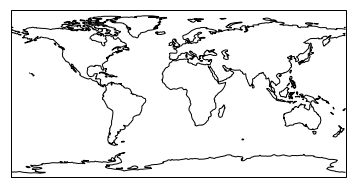

In [53]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

plt.show()

In [54]:
# list of state abbreviations
states = ['AL','AK','AZ','AR','CA','CO','CT','DC','DE','FL','GA','HI','ID','IL','IN','IA','KS','KY','LA','ME','MD','MA','MI','MN','MS','MO','MT','NE','NV','NH','NJ','NM','NY','NC','ND','OH','OK','OR','PA','RI','SC','SD','TN','TX','UT','VT','VA','WA','WV','WI','WY']

# headers for csv export
data = [['state_abbr', 'county_name', 'party', 'votes_total']]

# each page has a summary table that rolls up results at the state level
# get rid of it
def cond(x):
    if x:
        return x.startswith("table ec-table") and not "table ec-table ec-table-summary" in x
    else:
        return False

In [55]:
hdr = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.11 (KHTML, like Gecko) Chrome/23.0.1271.64 Safari/537.11',
       'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
       'Accept-Charset': 'ISO-8859-1,utf-8;q=0.7,*;q=0.3',
       'Accept-Encoding': 'none',
       'Accept-Language': 'en-US,en;q=0.8',
       'Connection': 'keep-alive'}


pb = progressbar.ProgressBar(max_value=len(states))
for i, state in enumerate(states):
    url = 'http://townhall.com/election/2016/president/' + state + '/county'
    req = urllib.request.Request(url, headers=hdr)
    with urllib.request.urlopen(req) as response:
        r = response.read()
    soup = BeautifulSoup(r, 'html.parser')
    # loop through each <table> tag with .ec-table class
    tables = soup.findAll('table', attrs={'class':cond})

    for table in tables:
        if table.findParent("table") is None:
            table_body = table.find('tbody')

            rows = table_body.find_all('tr')
            for row in rows:
                cols = row.find_all('td')
                # first tbody tr has four td
                if len(cols) == 4:
                    # strip text from each td
                    divs = cols[0].find_all('div')
                    county = divs[0].text.strip()
                    party = cols[1]['class'][0]
                    total_votes = int(cols[2].text.strip().replace(',','').replace('-','0'))
                # all other tbody tr have three td
                else:
                    party = cols[1]['class'][0]
                    total_votes = int(cols[1].text.strip().replace(',','').replace('-','0'))
                    
                #combine each row's results
                rowData = [state,county,party,total_votes]
                data.append(rowData)
    pb.update(i+1)
    pb.finish()
   

100% (51 of 51) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (51 of 51) |########################| Elapsed Time: 0:00:27 Time:  0:00:27

In [56]:
townhall = pd.DataFrame(data)
new_header = townhall.iloc[0]
townhall = townhall[1:]
townhall.columns = new_header
print(townhall.shape[0])
townhall.head()

14188


,state_abbr,county_name,party,votes_total
1,AL,Autauga,GOP,18110
2,AL,Autauga,DEM,5908
3,AL,Autauga,IND,538
4,AL,Autauga,IND,105
5,AL,Baldwin,GOP,72780


In [57]:
townhall[(townhall['state_abbr'] == 'AK')]

,state_abbr,county_name,party,votes_total
269,AK,Alaska,GOP,130415
270,AK,Alaska,DEM,93007
271,AK,Alaska,LIB,14593
272,AK,Alaska,GRN,4445
273,AK,Alaska,OTH,4128


In [58]:
print(townhall[(townhall['state_abbr'] == 'NV') & (townhall['county_name'] == 'Carson City')])

0    state_abbr  county_name party votes_total
7943         NV  Carson City   GOP       13125
7944         NV  Carson City   DEM        9610
7945         NV  Carson City   LIB        1159
7946         NV  Carson City   OTH        1122


In [59]:
townhall.loc[townhall['state_abbr'] == 'DC', 'county_name'] = 'District of Columbia'
townhall.loc[townhall['county_name'] == 'Sainte Genevieve', 'county_name'] = 'Ste. Genevieve County'
townhall.loc[townhall['county_name'] == 'Oglala Lakota', 'county_name'] = 'Oglala'
print(townhall[(townhall['county_name'] == 'District of Columbia') | (townhall['county_name'] == 'Ste. Genevieve County') | (townhall['county_name'] == 'Oglala')])


0     state_abbr            county_name party votes_total
1415          DC   District of Columbia   DEM      260223
1416          DC   District of Columbia   GOP       11553
1417          DC   District of Columbia   LIB        4501
1418          DC   District of Columbia   DCG        3995
7227          MO  Ste. Genevieve County   GOP        5495
7228          MO  Ste. Genevieve County   DEM        2540
7229          MO  Ste. Genevieve County   LIB         323
7230          MO  Ste. Genevieve County   GRN          55
7231          MO  Ste. Genevieve County   OTH          46
10780         SD                 Oglala   DEM        2504
10781         SD                 Oglala   GOP         241
10782         SD                 Oglala   LIB         104
10783         SD                 Oglala   OTH          47


In [60]:
co_names = townhall['county_name'].unique()
[print(co_names[i]) for i, x in enumerate(co_names) if "Co." in x]
print(townhall[(townhall['state_abbr'] == 'NV') & (townhall['county_name'] == 'Carson City')])

St. Louis Co.
Bedford Co.
Fairfax Co.
Franklin Co.
Richmond Co.
Roanoke Co.
0    state_abbr  county_name party votes_total
7943         NV  Carson City   GOP       13125
7944         NV  Carson City   DEM        9610
7945         NV  Carson City   LIB        1159
7946         NV  Carson City   OTH        1122


In [61]:
# change 'Co.' to 'County' in county_name to match census county name
townhall['county_name'] = townhall['county_name'].apply(lambda x: x.replace('Co.','County').strip())

In [62]:
townhall['combined'] = townhall['state_abbr'] + townhall['county_name'].apply(lambda x: x.replace(' ','').lower())
print(townhall[(townhall['state_abbr'] == 'NV') & (townhall['county_name'] == 'Carson City')])

0    state_abbr  county_name party votes_total      combined
7943         NV  Carson City   GOP       13125  NVcarsoncity
7944         NV  Carson City   DEM        9610  NVcarsoncity
7945         NV  Carson City   LIB        1159  NVcarsoncity
7946         NV  Carson City   OTH        1122  NVcarsoncity


In [63]:
# FIPS [https://en.wikipedia.org/wiki/FIPS_county_code]
# 
# county_fips data from https://www.census.gov/geo/reference/codes/cou.html
census = pd.read_csv('http://www2.census.gov/geo/docs/reference/codes/files/national_county.txt',sep=',',header=None, dtype=str)
census.columns = ['state_abbr', 'state_fips', 'county_fips', 'county_name', 'fips_class_code']
print(census.shape)
census.head()

(3235, 5)


,state_abbr,state_fips,county_fips,county_name,fips_class_code
0,AL,01,001,Autauga County,H1
1,AL,01,003,Baldwin County,H1
2,AL,01,005,Barbour County,H1
3,AL,01,007,Bibb County,H1
4,AL,01,009,Blount County,H1


In [64]:
ak_counties = census[(census['state_abbr'] == 'AK')].shape[0]
print(ak_counties)
census[(census['state_abbr'] == 'AK')]

29


,state_abbr,state_fips,county_fips,county_name,fips_class_code
67,AK,02,013,Aleutians East Borough,H1
68,AK,02,016,Aleutians West Census Area,H5
69,AK,02,020,Anchorage Municipality,H6
70,AK,02,050,Bethel Census Area,H5
71,AK,02,060,Bristol Bay Borough,H1
72,AK,02,068,Denali Borough,H1
73,AK,02,070,Dillingham Census Area,H5
74,AK,02,090,Fairbanks North Star Borough,H1
75,AK,02,100,Haines Borough,H1
76,AK,02,105,Hoonah-Angoon Census Area,H5


In [65]:
# veiw special cases
print(census[(census['state_abbr'] == 'NV') & (census['county_name'] == 'Carson City')])

     state_abbr state_fips county_fips  county_name fips_class_code
1763         NV         32         510  Carson City              C7


In [66]:
census[(census['fips_class_code'] == 'C7')]

,state_abbr,state_fips,county_fips,county_name,fips_class_code
1216,MD,24,510,Baltimore city,C7
1597,MO,29,510,St. Louis city,C7
1763,NV,32,510,Carson City,C7
2915,VA,51,510,Alexandria city,C7
2916,VA,51,515,Bedford city,C7
2917,VA,51,520,Bristol city,C7
2918,VA,51,530,Buena Vista city,C7
2919,VA,51,540,Charlottesville city,C7
2920,VA,51,550,Chesapeake city,C7
2921,VA,51,570,Colonial Heights city,C7


In [67]:
# change Shannon County, SD to Oglala County, SD
# http://rapidcityjournal.com/news/local/it-s-official-oglala-lakota-county-replaces-shannon-county-name/article_ac5c2369-3fea-5f94-9898-b007b7ddf22c.html
# townhall.loc[townhall['county_name'] == 'Sainte Genevieve', 'county_name'] = 'Ste. Genevieve County'
census.loc[(census['county_name'] == 'Shannon County') & (census['state_abbr'] == 'SD'), 'county_name'] = 'Oglala County'
census[(census['state_abbr'] == 'SD')]

,state_abbr,state_fips,county_fips,county_name,fips_class_code
2362,SD,46,003,Aurora County,H1
2363,SD,46,005,Beadle County,H1
2364,SD,46,007,Bennett County,H1
2365,SD,46,009,Bon Homme County,H1
2366,SD,46,011,Brookings County,H1
2367,SD,46,013,Brown County,H1
2368,SD,46,015,Brule County,H1
2369,SD,46,017,Buffalo County,H1
2370,SD,46,019,Butte County,H1
2371,SD,46,021,Campbell County,H1


In [68]:
# state of Alaska reports results at the precinct and state level; no county level data available
# report results as the states level; 
# ugly fix to get townhall results and census counties to work together
# future plan: roll up precinct-level results to the county level
census.loc[(census['state_abbr'] == 'AK'),'county_name'] = 'Alaska'

In [69]:
# change county_name values in townhall data to match 'county_name' values for C7 fips class code cities
# get and transform C7 city names
cities = (census['state_abbr'][(census['fips_class_code'] == 'C7')] + census['county_name'][(census['fips_class_code'] == 'C7')].apply(lambda x: x.replace('city','').replace(' ','').lower()))
cities

1216          MDbaltimore
1597           MOst.louis
1763         NVcarsoncity
2915         VAalexandria
2916            VAbedford
2917            VAbristol
2918         VAbuenavista
2919    VAcharlottesville
2920         VAchesapeake
2921    VAcolonialheights
2922          VAcovington
2923           VAdanville
2924            VAemporia
2925            VAfairfax
2926        VAfallschurch
2927           VAfranklin
2928     VAfredericksburg
2929              VAgalax
2930            VAhampton
2931       VAharrisonburg
2932           VAhopewell
2933          VAlexington
2934          VAlynchburg
2935           VAmanassas
2936       VAmanassaspark
2937       VAmartinsville
2938        VAnewportnews
2939            VAnorfolk
2940             VAnorton
2941         VApetersburg
2942           VApoquoson
2943         VAportsmouth
2944            VAradford
2945           VArichmond
2946            VAroanoke
2947              VAsalem
2948           VAstaunton
2949            VAsuffolk
2950      VA

In [70]:
# loop through 'combined' column and compare to cities series to add 'city' to H1 fips class code to townhall data
for i, row in cities.iteritems():
    if row != 'NVcarsoncity':
        townhall.loc[townhall['combined'] == row, 'combined'] = row + 'city'
    
print(townhall[(townhall['combined'] == 'NVcarsoncity')])

0    state_abbr  county_name party votes_total      combined
7943         NV  Carson City   GOP       13125  NVcarsoncity
7944         NV  Carson City   DEM        9610  NVcarsoncity
7945         NV  Carson City   LIB        1159  NVcarsoncity
7946         NV  Carson City   OTH        1122  NVcarsoncity


In [71]:
# remove 'county' from 'combined' column of C7 fips class code counties in townhall
townhall['combined'] = townhall['combined'].str.replace('county','')
print(townhall[(townhall['county_name'] == 'Oglala')])

0     state_abbr county_name party votes_total  combined
10780         SD      Oglala   DEM        2504  SDoglala
10781         SD      Oglala   GOP         241  SDoglala
10782         SD      Oglala   LIB         104  SDoglala
10783         SD      Oglala   OTH          47  SDoglala


In [72]:
census['combined'] = census['state_abbr'] + census['county_name'].apply(lambda x: x.replace('County','').replace('Parish','').replace(' ','').lower())
print(census[(census['state_abbr'] == 'NV') & (census['county_name'] == 'Carson City')])
# print(census[(census['state_abbr'] == 'VA') & (census['county_name'] == 'Bedford County')])


     state_abbr state_fips county_fips  county_name fips_class_code  \
1763         NV         32         510  Carson City              C7   

          combined  
1763  NVcarsoncity  


In [73]:
# return sum of votes by state and county
townhall['total_votes'] = townhall['votes_total'].groupby(townhall['combined']).transform('sum')
townhall_counties = townhall.drop('votes_total',axis=1)

# view dataset by selected state
print(townhall_counties[(townhall_counties['state_abbr'] == 'NV') & (townhall_counties['county_name'] == 'Carson City')])

0    state_abbr  county_name party      combined  total_votes
7943         NV  Carson City   GOP  NVcarsoncity        25016
7944         NV  Carson City   DEM  NVcarsoncity        25016
7945         NV  Carson City   LIB  NVcarsoncity        25016
7946         NV  Carson City   OTH  NVcarsoncity        25016


In [74]:
# join census and townhall data on the 'combined' column
right = townhall.set_index('combined')
left = census.set_index('combined')

In [75]:
combined = left.join(right, lsuffix='', rsuffix='_r')
combined = combined.reset_index()
print('Joined dataset has ' + str(combined.shape[0]) + ' items')

Joined dataset has 14422 items


In [76]:
# view data by selected state
combined[(combined['state_abbr'] == 'NV') & (combined['fips_class_code'] == 'C7')]

,combined,state_abbr,state_fips,county_fips,county_name,fips_class_code,state_abbr_r,county_name_r,party,votes_total,total_votes
8968,NVcarsoncity,NV,32,510,Carson City,C7,NV,Carson City,GOP,13125,25016.0
8969,NVcarsoncity,NV,32,510,Carson City,C7,NV,Carson City,DEM,9610,25016.0
8970,NVcarsoncity,NV,32,510,Carson City,C7,NV,Carson City,LIB,1159,25016.0
8971,NVcarsoncity,NV,32,510,Carson City,C7,NV,Carson City,OTH,1122,25016.0


In [77]:
# scale Alaska by number of counties
combined.loc[(combined['state_abbr'] == 'AK'),'votes_total'] = (combined['votes_total'][combined['state_abbr'] == 'AK']/ak_counties).astype(int)
combined[combined['state_abbr'] == 'AK']

,combined,state_abbr,state_fips,county_fips,county_name,fips_class_code,state_abbr_r,county_name_r,party,votes_total,total_votes
0,AKalaska,AK,02,013,Alaska,H1,AK,Alaska,GOP,4497,246588.0
1,AKalaska,AK,02,013,Alaska,H1,AK,Alaska,DEM,3207,246588.0
2,AKalaska,AK,02,013,Alaska,H1,AK,Alaska,LIB,503,246588.0
3,AKalaska,AK,02,013,Alaska,H1,AK,Alaska,GRN,153,246588.0
4,AKalaska,AK,02,013,Alaska,H1,AK,Alaska,OTH,142,246588.0
5,AKalaska,AK,02,016,Alaska,H5,AK,Alaska,GOP,4497,246588.0
6,AKalaska,AK,02,016,Alaska,H5,AK,Alaska,DEM,3207,246588.0
7,AKalaska,AK,02,016,Alaska,H5,AK,Alaska,LIB,503,246588.0
8,AKalaska,AK,02,016,Alaska,H5,AK,Alaska,GRN,153,246588.0
9,AKalaska,AK,02,016,Alaska,H5,AK,Alaska,OTH,142,246588.0


In [78]:
county_level_combined = combined.drop_duplicates()
print('Combined dataset has ' + str(county_level_combined.shape[0]) + ' total items (comared to {})'.format(combined.shape[0]))

Combined dataset has 14421 total items (comared to 14422)


In [79]:
# return only D and R results
county_level_combined = county_level_combined[(county_level_combined['party'] == 'GOP') | (county_level_combined['party'] == 'DEM')]
print('Filtered dataset has ' + str(county_level_combined.shape[0]) + ' D and R items')


Filtered dataset has 6282 D and R items


In [80]:
# flatten dataset by adding votes by R and D columns
county_level_combined['votes_dem'] = county_level_combined['votes_total'].where(county_level_combined['party'] == 'DEM',0).astype('float32')
county_level_combined['votes_gop'] = county_level_combined['votes_total'].where(county_level_combined['party'] == 'GOP',0).astype('float32')

In [81]:
# drop party and party-level totals and other columns
county_level_combined.drop(['party','votes_total','state_abbr_r','county_name_r'], axis=1, inplace=True)
# total_results = county_level_combined.drop(['party','votes_total','fips_class_code','state_abbr_r','county_name_r', 'votes_dem', 'votes_gop'], axis=1, inplace=True)
county_level_combined[(county_level_combined['state_abbr'] == 'NV') & (county_level_combined['fips_class_code'] == 'C7')]

,combined,state_abbr,state_fips,county_fips,county_name,fips_class_code,total_votes,votes_dem,votes_gop
8968,NVcarsoncity,NV,32,510,Carson City,C7,25016.0,0.0,13125.0
8969,NVcarsoncity,NV,32,510,Carson City,C7,25016.0,9610.0,0.0


In [82]:
# pivot data to consolidate
party_pivot = pd.pivot_table(county_level_combined,index=["combined"],values=["votes_dem","votes_gop"],aggfunc=np.sum)
total_pivot = pd.pivot_table(county_level_combined,index=["combined"],values=["total_votes"],aggfunc=np.mean)

In [83]:
party_pivot.head()

,votes_dem,votes_gop
combined,,
AKalaska,93003.0,130413.0
ALautauga,5908.0,18110.0
ALbaldwin,18409.0,72780.0
ALbarbour,4848.0,5431.0
ALbibb,1874.0,6733.0


In [84]:
total_pivot.head()

,total_votes
combined,
AKalaska,246588.0
ALautauga,24661.0
ALbaldwin,94090.0
ALbarbour,10390.0
ALbibb,8748.0


In [85]:
# join party and total pivots
combined_pivot = party_pivot.join(total_pivot, lsuffix='', rsuffix='_r')
print('Joined dataset has ' + str(combined_pivot.shape[0]) + ' items')
combined_pivot

Joined dataset has 3113 items


,votes_dem,votes_gop,total_votes
combined,,,
AKalaska,93003.0,130413.0,246588.0
ALautauga,5908.0,18110.0,24661.0
ALbaldwin,18409.0,72780.0,94090.0
ALbarbour,4848.0,5431.0,10390.0
ALbibb,1874.0,6733.0,8748.0
ALblount,2150.0,22808.0,25384.0
ALbullock,3530.0,1139.0,4701.0
ALbutler,3716.0,4891.0,8685.0
ALcalhoun,13197.0,32803.0,47376.0


In [86]:
# add percentages for each R and D of total votes
# calculate percentage of total vote per major candidates
combined_pivot['per_dem'] = combined_pivot['votes_dem'] / combined_pivot['total_votes']
combined_pivot['per_gop'] = combined_pivot['votes_gop'] / combined_pivot['total_votes']
combined_pivot['diff'] = abs(combined_pivot['votes_gop'] - combined_pivot['votes_dem']).map('{:,.0f}'.format)
combined_pivot['per_point_diff'] = abs(combined_pivot['per_dem'] - combined_pivot['per_gop']).map('{:,.2%}'.format)

In [87]:
combined_pivot.head()

,votes_dem,votes_gop,total_votes,per_dem,per_gop,diff,per_point_diff
combined,,,,,,,
AKalaska,93003.0,130413.0,246588.0,0.377159,0.528870,"37,410",15.17%
ALautauga,5908.0,18110.0,24661.0,0.239569,0.734358,"12,202",49.48%
ALbaldwin,18409.0,72780.0,94090.0,0.195653,0.773515,"54,371",57.79%
ALbarbour,4848.0,5431.0,10390.0,0.466603,0.522714,583,5.61%
ALbibb,1874.0,6733.0,8748.0,0.214220,0.769662,"4,859",55.54%


In [88]:
# join pivotted and unpivotted data
right = census.set_index('combined')
# left = combined_pivot.set_index('combined')

In [89]:
right.head()

,state_abbr,state_fips,county_fips,county_name,fips_class_code
combined,,,,,
ALautauga,AL,01,001,Autauga County,H1
ALbaldwin,AL,01,003,Baldwin County,H1
ALbarbour,AL,01,005,Barbour County,H1
ALbibb,AL,01,007,Bibb County,H1
ALblount,AL,01,009,Blount County,H1


In [90]:
county_level_final = combined_pivot.join(right, lsuffix='', rsuffix='_r')
county_level_final = county_level_final.reset_index()
print('Joined dataset has ' + str(county_level_final.shape[0]) + ' items')
county_level_final

Joined dataset has 3141 items


,combined,votes_dem,votes_gop,total_votes,per_dem,per_gop,diff,per_point_diff,state_abbr,state_fips,county_fips,county_name,fips_class_code
0,AKalaska,93003.0,130413.0,246588.0,0.377159,0.528870,"37,410",15.17%,AK,02,013,Alaska,H1
1,AKalaska,93003.0,130413.0,246588.0,0.377159,0.528870,"37,410",15.17%,AK,02,016,Alaska,H5
2,AKalaska,93003.0,130413.0,246588.0,0.377159,0.528870,"37,410",15.17%,AK,02,020,Alaska,H6
3,AKalaska,93003.0,130413.0,246588.0,0.377159,0.528870,"37,410",15.17%,AK,02,050,Alaska,H5
4,AKalaska,93003.0,130413.0,246588.0,0.377159,0.528870,"37,410",15.17%,AK,02,060,Alaska,H1
5,AKalaska,93003.0,130413.0,246588.0,0.377159,0.528870,"37,410",15.17%,AK,02,068,Alaska,H1
6,AKalaska,93003.0,130413.0,246588.0,0.377159,0.528870,"37,410",15.17%,AK,02,070,Alaska,H5
7,AKalaska,93003.0,130413.0,246588.0,0.377159,0.528870,"37,410",15.17%,AK,02,090,Alaska,H1
8,AKalaska,93003.0,130413.0,246588.0,0.377159,0.528870,"37,410",15.17%,AK,02,100,Alaska,H1
9,AKalaska,93003.0,130413.0,246588.0,0.377159,0.528870,"37,410",15.17%,AK,02,105,Alaska,H5


In [91]:
# create FIPS columns for visualizations
county_level_final['combined_fips'] = county_level_final['state_fips'].apply(lambda x: x.lstrip('0')) + county_level_final['county_fips']
county_level_final

,combined,votes_dem,votes_gop,total_votes,per_dem,per_gop,diff,per_point_diff,state_abbr,state_fips,county_fips,county_name,fips_class_code,combined_fips
0,AKalaska,93003.0,130413.0,246588.0,0.377159,0.528870,"37,410",15.17%,AK,02,013,Alaska,H1,2013
1,AKalaska,93003.0,130413.0,246588.0,0.377159,0.528870,"37,410",15.17%,AK,02,016,Alaska,H5,2016
2,AKalaska,93003.0,130413.0,246588.0,0.377159,0.528870,"37,410",15.17%,AK,02,020,Alaska,H6,2020
3,AKalaska,93003.0,130413.0,246588.0,0.377159,0.528870,"37,410",15.17%,AK,02,050,Alaska,H5,2050
4,AKalaska,93003.0,130413.0,246588.0,0.377159,0.528870,"37,410",15.17%,AK,02,060,Alaska,H1,2060
5,AKalaska,93003.0,130413.0,246588.0,0.377159,0.528870,"37,410",15.17%,AK,02,068,Alaska,H1,2068
6,AKalaska,93003.0,130413.0,246588.0,0.377159,0.528870,"37,410",15.17%,AK,02,070,Alaska,H5,2070
7,AKalaska,93003.0,130413.0,246588.0,0.377159,0.528870,"37,410",15.17%,AK,02,090,Alaska,H1,2090
8,AKalaska,93003.0,130413.0,246588.0,0.377159,0.528870,"37,410",15.17%,AK,02,100,Alaska,H1,2100
9,AKalaska,93003.0,130413.0,246588.0,0.377159,0.528870,"37,410",15.17%,AK,02,105,Alaska,H5,2105


In [92]:
# drop irrelevant columns
county_level_final = county_level_final.drop(['combined','county_fips','state_fips','fips_class_code'], axis=1)
print('Final dataset has ' + str(county_level_final.shape[0]) + ' items')
county_level_final

Final dataset has 3141 items


,votes_dem,votes_gop,total_votes,per_dem,per_gop,diff,per_point_diff,state_abbr,county_name,combined_fips
0,93003.0,130413.0,246588.0,0.377159,0.528870,"37,410",15.17%,AK,Alaska,2013
1,93003.0,130413.0,246588.0,0.377159,0.528870,"37,410",15.17%,AK,Alaska,2016
2,93003.0,130413.0,246588.0,0.377159,0.528870,"37,410",15.17%,AK,Alaska,2020
3,93003.0,130413.0,246588.0,0.377159,0.528870,"37,410",15.17%,AK,Alaska,2050
4,93003.0,130413.0,246588.0,0.377159,0.528870,"37,410",15.17%,AK,Alaska,2060
5,93003.0,130413.0,246588.0,0.377159,0.528870,"37,410",15.17%,AK,Alaska,2068
6,93003.0,130413.0,246588.0,0.377159,0.528870,"37,410",15.17%,AK,Alaska,2070
7,93003.0,130413.0,246588.0,0.377159,0.528870,"37,410",15.17%,AK,Alaska,2090
8,93003.0,130413.0,246588.0,0.377159,0.528870,"37,410",15.17%,AK,Alaska,2100
9,93003.0,130413.0,246588.0,0.377159,0.528870,"37,410",15.17%,AK,Alaska,2105


In [93]:
# view data by selected state
county_level_final[(county_level_final['state_abbr'] == 'AK')]

,votes_dem,votes_gop,total_votes,per_dem,per_gop,diff,per_point_diff,state_abbr,county_name,combined_fips
0,93003.0,130413.0,246588.0,0.377159,0.52887,"37,410",15.17%,AK,Alaska,2013
1,93003.0,130413.0,246588.0,0.377159,0.52887,"37,410",15.17%,AK,Alaska,2016
2,93003.0,130413.0,246588.0,0.377159,0.52887,"37,410",15.17%,AK,Alaska,2020
3,93003.0,130413.0,246588.0,0.377159,0.52887,"37,410",15.17%,AK,Alaska,2050
4,93003.0,130413.0,246588.0,0.377159,0.52887,"37,410",15.17%,AK,Alaska,2060
5,93003.0,130413.0,246588.0,0.377159,0.52887,"37,410",15.17%,AK,Alaska,2068
6,93003.0,130413.0,246588.0,0.377159,0.52887,"37,410",15.17%,AK,Alaska,2070
7,93003.0,130413.0,246588.0,0.377159,0.52887,"37,410",15.17%,AK,Alaska,2090
8,93003.0,130413.0,246588.0,0.377159,0.52887,"37,410",15.17%,AK,Alaska,2100
9,93003.0,130413.0,246588.0,0.377159,0.52887,"37,410",15.17%,AK,Alaska,2105


In [94]:
county_level_final.to_csv('data/US_voting/2016_US_County_Level_Presidential_Results.csv',sep=',')

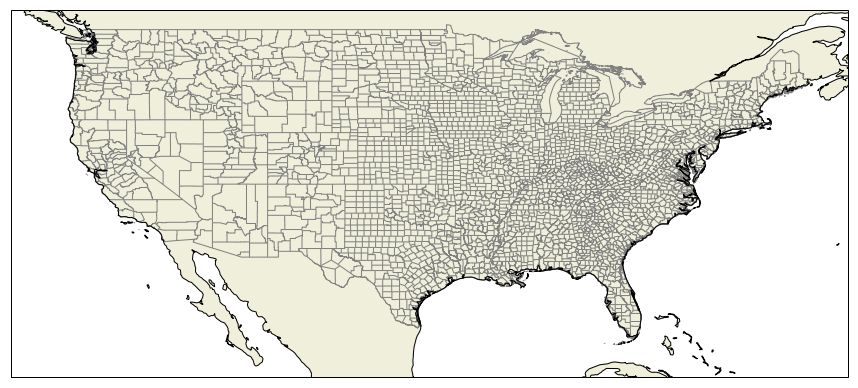

In [95]:
reader = shpreader.Reader('data/US_voting/county_shapes/countyl010g.shp')

counties = list(reader.geometries())
countries = list(reader.records())

COUNTIES = cfeature.ShapelyFeature(counties, ccrs.PlateCarree())

plt.figure(figsize=(15, 9))
ax = plt.axes(projection=ccrs.PlateCarree())

lllon = -129
urlon = -64
lllat = 22.0
urlat = 50.5
# and calculate a centerpoint, needed for the projection:
centerlon = float(lllon + urlon) / 2.0
centerlat = float(lllat + urlat) / 2.0


ax.set_extent([lllon, urlon, lllat, urlat], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND.with_scale('50m'))
# ax.add_feature(cfeature.OCEAN.with_scale('50m'))
# ax.add_feature(cfeature.LAKES.with_scale('50m'))
ax.add_feature(COUNTIES, facecolor='none', edgecolor='gray')
ax.coastlines('50m')

In [99]:
reader = shpreader.Reader('data/US_voting/cb_2016_us_county_20m/cb_2016_us_county_20m.shp')
records = list(reader.records())

In [100]:
cols = sns.color_palette('BuGn_r', n_colors=len(records))

In [109]:
# plt.figure(figsize=(18, 12))
# ax = plt.axes(projection=ccrs.PlateCarree())

# lllon = -129
# urlon = -64
# lllat = 22.0
# urlat = 50.5
# # and calculate a centerpoint, needed for the projection:
# centerlon = float(lllon + urlon) / 2.0
# centerlat = float(lllat + urlat) / 2.0

# ax.set_extent([lllon, urlon, lllat, urlat], crs=ccrs.PlateCarree())
# ax.add_feature(cfeature.LAND.with_scale('50m'))
# for i, record in enumerate(records):
#     county_col = get_county_voting_color(county_level_final, record)
#     geometry = record.geometry
    
#     combined_fp = get_county_fips(county_level_final, record)
#     if combined_fp in hawaii_alaska_fips:
#         geometry.bounds += [lllon, urlon, lllat, urlat]
        
    
#     ax.add_geometries([geometry], ccrs.PlateCarree(),
#                       facecolor=county_col, edgecolor='k', 
#                       lw=0.5, zorder=5)
# # ax.add_feature(cfeature.OCEAN.with_scale('50m'))
# # ax.add_feature(cfeature.LAKES.with_scale('50m'))
# ax.coastlines('50m')

In [259]:
record

<Record: <shapely.geometry.multipolygon.MultiPolygon object at 0x10d863358>, {'STATEFP': '39', 'COUNTYFP': '131', 'COUNTYNS': '01074078', 'AFFGEOID': '0500000US39131', 'GEOID': '39131', 'NAME': 'Pike', 'LSAD': '06', 'ALAND': 1140324458, 'AWATER': 9567612}, <fields>>

In [491]:
hawaii_fips = county_level_final[(county_level_final['state_abbr'] == 'HI')]['combined_fips'].values
alaska_fips = county_level_final[(county_level_final['state_abbr'] == 'AK')]['combined_fips'].values

from shapely import affinity
from shapely.geometry import mapping, shape

def get_county_fips(record) -> str:
    combined_fp = record.attributes['STATEFP'] + record.attributes['COUNTYFP']
    if combined_fp[0]=='0':
        combined_fp = combined_fp[1:]
    return combined_fp

def get_hi_ak_geom(records):
    hi_ak_geoms = {'HI': [], 'AK': []}
    for i, record in enumerate(records):
        combined_fp = get_county_fips(record)
        if combined_fp in hawaii_fips:
            hi_ak_geoms['HI'].append(record.geometry)
        elif combined_fp in alaska_fips:
            hi_ak_geoms['AK'].append(record.geometry)
    return hi_ak_geoms

hi_ak_geoms = get_hi_ak_geom(records=records)

def get_county_pop_density(record, df) -> float:
    combined_fp = get_county_fips(record)
    land_area = record.attributes['ALAND']/(1000.0*1000.0)
    pop = df[(df['combined_fips'] == combined_fp)]['TOT_POP']
    return pop/land_area

def get_county_voting_color(record, df, *args) -> list:
    combined_fp = get_county_fips(record)
    divisor = df.loc[combined_fp][args[2]] if (len(args)==3 and isinstance(args[2], str) and combined_fp in plot_df.index) else args[2] if (len(args)==3 and isinstance(args[2], (int, float))) else 1.0
    try:            
        blue = df[(df['combined_fips'] == combined_fp)][args[0]].values[0]
        red = df[(df['combined_fips'] == combined_fp)][args[1]].values[0]
    except AttributeError as ae:
        blue = df[(df['combined_fips'] == combined_fp)][args[0]]
        red = df[(df['combined_fips'] == combined_fp)][args[1]]
    except Exception as e:
        try:
            blue = df.loc[combined_fp][args[0]].values[0]
            red = df.loc[combined_fp][args[1]].values[0]
        except AttributeError as ae:
            blue = df.loc[combined_fp][args[0]]
            red = df.loc[combined_fp][args[1]]
        except KeyError as ke:
            divisor = 1.0
            blue = 0
            red = 0
    blue_val = blue/divisor
    red_val = red/divisor
    return [red_val, 0, blue_val]

In [301]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.gridspec as gridspec

def plot_heatmaps_by_count(df, *args):
    
    if not args:
        args = ['per_dem', 'per_gop']
    
    fig = plt.figure(figsize=(20,14))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 3], height_ratios=[1])
    ax = []
    ax.append(plt.subplot(gs[0], projection=ccrs.PlateCarree()))
    ax.append(plt.subplot(gs[1], projection=ccrs.PlateCarree()))

    lllon = -126
    urlon = -65
    lllat = 24.0
    urlat = 50.5

    hi_ak = [-159, -112, 22, 45]

    ax[1].set_extent([lllon, urlon, lllat, urlat], crs=ccrs.PlateCarree())
    ax[0].set_extent(hi_ak, crs=ccrs.PlateCarree())

    # ax[0].add_feature(cfeature.LAND.with_scale('50m'))
    ax[1].add_feature(cfeature.LAND.with_scale('50m'))
    # ax[0].coastlines('50m')
    ax[1].coastlines('50m')

    for i, record in enumerate(records):
        county_col = get_county_voting_color(record, df, *args)
        geometry = record.geometry
        combined_fp = get_county_fips(record)
        if geometry in hi_ak_geoms['HI']:    
            geom = affinity.translate(geom=geometry, xoff=30, yoff=5)
            ax[0].add_geometries([geom], ccrs.PlateCarree(), facecolor=county_col, edgecolor='k', 
                          lw=0.5, zorder=5)
        elif geometry in hi_ak_geoms['AK']:    
            geom = affinity.translate(geom=geometry, xoff=16, yoff=-30)
            ax[0].add_geometries([geom], ccrs.PlateCarree(), facecolor=county_col, edgecolor='k', 
                          lw=0.5, zorder=5)
        else:
            ax[1].add_geometries([geometry], ccrs.PlateCarree(),
                          facecolor=county_col, edgecolor='k', 
                          lw=0.5, zorder=5)
    plt.show()

In [667]:
keys = \
"""SUMLEV STATE COUNTY STNAME CTYNAME YEAR AGEGRP TOT_POP TOT_MALE TOT_FEMALE WA_MALE WA_FEMALE BA_MALE BA_FEMALE IA_MALE IA_FEMALE AA_MALE AA_FEMALE NA_MALE NA_FEMALE TOM_MALE TOM_FEMALE WAC_MALE WAC_FEMALE BAC_MALE BAC_FEMALE IAC_MALE IAC_FEMALE AAC_MALE AAC_FEMALE NAC_MALE NAC_FEMALE NH_MALE NH_FEMALE NHWA_MALE NHWA_FEMALE NHBA_MALE NHBA_FEMALE NHIA_MALE NHIA_FEMALE NHAA_MALE NHAA_FEMALE NHNA_MALE NHNA_FEMALE NHTOM_MALE NHTOM_FEMALE NHWAC_MALE NHWAC_FEMALE NHBAC_MALE NHBAC_FEMALE NHIAC_MALE NHIAC_FEMALE NHAAC_MALE NHAAC_FEMALE NHNAC_MALE NHNAC_FEMALE H_MALE H_FEMALE HWA_MALE HWA_FEMALE HBA_MALE HBA_FEMALE HIA_MALE HIA_FEMALE HAA_MALE HAA_FEMALE HNA_MALE HNA_FEMALE HTOM_MALE HTOM_FEMALE HWAC_MALE HWAC_FEMALE HBAC_MALE HBAC_FEMALE HIAC_MALE HIAC_FEMALE HAAC_MALE HAAC_FEMALE HNAC_MALE HNAC_FEMALE POP_DENSITY"""

vals = \
"""Geographic Summary Level
State FIPS code
County FIPS code
State Name
County Name
Year
Age group
Total population
Total male population
Total female population
White alone male population
White alone female population
Black or African American alone male population
Black or African American alone female population
American Indian and Alaska Native alone male population 
American Indian and Alaska Native alone female population 
Asian alone male population
Asian alone female population
Native Hawaiian and Other Pacific Islander alone male population 
Native Hawaiian and Other Pacific Islander alone female population
Two or More Races male population
Two or More Races female population
White alone or in combination male population
White alone or in combination female population
Black or African American alone or in combination male population
Black or African American alone or in combination female population
American Indian and Alaska Native alone or in combination male population
American Indian and Alaska Native alone or in combination female population
Asian alone or in combination male population
Asian alone or in combination female population
Native Hawaiian and Other Pacific Islander alone or in combination male population
Native Hawaiian and Other Pacific Islander alone or in combination female population
Not Hispanic male population
Not Hispanic female population
Not Hispanic, White alone male population
Not Hispanic, White alone female population
Not Hispanic, Black or African American alone male population 
Not Hispanic, Black or African American alone female population 
Not Hispanic, American Indian and Alaska Native alone male population
Not Hispanic, American Indian and Alaska Native alone female population
Not Hispanic, Asian alone male population
Not Hispanic, Asian alone female population
Not Hispanic, Native Hawaiian and Other Pacific Islander alone male population
Not Hispanic, Native Hawaiian and Other Pacific Islander alone female population
Not Hispanic, Two or More Races male population
Not Hispanic, Two or More Races female population
Not Hispanic, White alone or in combination male population
Not Hispanic, White alone or in combination female population
Not Hispanic, Black or African American alone or in combination male population
Not Hispanic, Black or African American alone or in combination female population
Not Hispanic, American Indian and Alaska Native alone or in combination male population
Not Hispanic, American Indian and Alaska Native alone or in combination female population
Not Hispanic, Asian alone or in combination male population
Not Hispanic, Asian alone or in combination female population
Not Hispanic, Native Hawaiian and Other Pacific Islander alone or in combination male population
Not Hispanic, Native Hawaiian and Other Pacific Islander alone or in combination female population
Hispanic male population
Hispanic female population
Hispanic, White alone male population
Hispanic, White alone female population
Hispanic, Black or African American alone male population 
Hispanic, Black or African American alone female population
Hispanic, American Indian and Alaska Native alone male population
Hispanic, American Indian and Alaska Native alone female population
Hispanic, Asian alone male population
Hispanic, Asian alone female population
Hispanic, Native Hawaiian and Other Pacific Islander alone male population
Hispanic, Native Hawaiian and Other Pacific Islander alone female population
Hispanic, Two or More Races male population
Hispanic, Two or More Races female population
Hispanic, White alone or in combination male population
Hispanic, White alone or in combination female population 
Hispanic, Black or African American alone or in combination male population
Hispanic, Black or African American alone or in combination female population
Hispanic, American Indian and Alaska Native alone or in combination male population
Hispanic, American Indian and Alaska Native alone or in combination female population
Hispanic, Asian alone or in combination male population
Hispanic, Asian alone or in combination female population 
Hispanic, Native Hawaiian and Other Pacific Islander alone or in combination male population
Hispanic, Native Hawaiian and Other Pacific Islander alone or in combination female population
Population Density"""

In [668]:
keys = keys.split(" ")
vals = vals.split("\n")
print(len(keys))
print(len(vals))
assert len(keys)==len(vals)
total_legend = len(keys)
legend = {}
for i in range(total_legend):
    legend[keys[i]] = vals[i]

81
81


In [114]:
population_df = pd.read_csv('data/US_voting/cc-est2017-alldata.csv', encoding = "ISO-8859-1")
population_df.head()

,SUMLEV,STATE,COUNTY,STNAME,CTYNAME,YEAR,AGEGRP,TOT_POP,TOT_MALE,TOT_FEMALE,...,HWAC_MALE,HWAC_FEMALE,HBAC_MALE,HBAC_FEMALE,HIAC_MALE,HIAC_FEMALE,HAAC_MALE,HAAC_FEMALE,HNAC_MALE,HNAC_FEMALE
0,50,1,1,Alabama,Autauga County,1,0,54571,26569,28002,...,607,538,57,48,26,32,9,11,19,10
1,50,1,1,Alabama,Autauga County,1,1,3579,1866,1713,...,77,56,9,5,4,1,0,0,2,1
2,50,1,1,Alabama,Autauga County,1,2,3991,2001,1990,...,64,66,2,3,2,7,2,3,2,0
3,50,1,1,Alabama,Autauga County,1,3,4290,2171,2119,...,51,57,13,7,5,5,2,1,1,1
4,50,1,1,Alabama,Autauga County,1,4,4290,2213,2077,...,48,44,7,5,0,2,2,1,3,1


In [115]:
population_df['combined_fips'] = population_df['STATE'].apply(lambda x: str(x).lstrip('0')) + population_df['COUNTY'].apply(lambda x: '00'+str(x) if len(str(x))==1 else '0'+str(x) if len(str(x))==2 else str(x))
population_df.head()

,SUMLEV,STATE,COUNTY,STNAME,CTYNAME,YEAR,AGEGRP,TOT_POP,TOT_MALE,TOT_FEMALE,...,HWAC_FEMALE,HBAC_MALE,HBAC_FEMALE,HIAC_MALE,HIAC_FEMALE,HAAC_MALE,HAAC_FEMALE,HNAC_MALE,HNAC_FEMALE,combined_fips
0,50,1,1,Alabama,Autauga County,1,0,54571,26569,28002,...,538,57,48,26,32,9,11,19,10,1001
1,50,1,1,Alabama,Autauga County,1,1,3579,1866,1713,...,56,9,5,4,1,0,0,2,1,1001
2,50,1,1,Alabama,Autauga County,1,2,3991,2001,1990,...,66,2,3,2,7,2,3,2,0,1001
3,50,1,1,Alabama,Autauga County,1,3,4290,2171,2119,...,57,13,7,5,5,2,1,1,1,1001
4,50,1,1,Alabama,Autauga County,1,4,4290,2213,2077,...,44,7,5,0,2,2,1,3,1,1001


In [247]:
right = county_level_final.set_index('combined_fips')
left = population_df.loc[(population_df['YEAR']==9) & (population_df['AGEGRP']==0)].set_index('combined_fips')
population_and_vote_df = left.join(right, lsuffix='', rsuffix='_r')
population_and_vote_df = population_and_vote_df.reset_index()
print('Joined dataset has ' + str(population_and_vote_df.shape[0]) + ' items')

Joined dataset has 3142 items


In [502]:
fip_to_land_area = {}
for i, record in enumerate(records):
    land_area = record.attributes['ALAND']/(1000.0*1000.0)
    fip_to_land_area[get_county_fips(record)] = land_area

def pop_density(row):
    return row['TOT_POP']/fip_to_land_area[row['combined_fips']]

population_and_vote_df['POP_DENSITY'] = population_and_vote_df.apply(pop_density, axis=1)

In [503]:
population_and_vote_df['POP_DENSITY'].describe()

count     3142.000000
mean       104.982551
std        706.970288
min          0.014362
25%          6.476804
50%         17.265151
75%         44.939590
max      28327.194534
Name: POP_DENSITY, dtype: float64

In [248]:
value_vars = ['TOT_POP', 'TOT_MALE', 'TOT_FEMALE', 'WA_MALE',
       'WA_FEMALE', 'BA_MALE', 'BA_FEMALE', 'IA_MALE', 'IA_FEMALE', 'AA_MALE',
       'AA_FEMALE', 'NA_MALE', 'NA_FEMALE', 'TOM_MALE', 'TOM_FEMALE',
       'WAC_MALE', 'WAC_FEMALE', 'BAC_MALE', 'BAC_FEMALE', 'IAC_MALE',
       'IAC_FEMALE', 'AAC_MALE', 'AAC_FEMALE', 'NAC_MALE', 'NAC_FEMALE',
       'NH_MALE', 'NH_FEMALE', 'NHWA_MALE', 'NHWA_FEMALE', 'NHBA_MALE',
       'NHBA_FEMALE', 'NHIA_MALE', 'NHIA_FEMALE', 'NHAA_MALE', 'NHAA_FEMALE',
       'NHNA_MALE', 'NHNA_FEMALE', 'NHTOM_MALE', 'NHTOM_FEMALE', 'NHWAC_MALE',
       'NHWAC_FEMALE', 'NHBAC_MALE', 'NHBAC_FEMALE', 'NHIAC_MALE',
       'NHIAC_FEMALE', 'NHAAC_MALE', 'NHAAC_FEMALE', 'NHNAC_MALE',
       'NHNAC_FEMALE', 'H_MALE', 'H_FEMALE', 'HWA_MALE', 'HWA_FEMALE',
       'HBA_MALE', 'HBA_FEMALE', 'HIA_MALE', 'HIA_FEMALE', 'HAA_MALE',
       'HAA_FEMALE', 'HNA_MALE', 'HNA_FEMALE', 'HTOM_MALE', 'HTOM_FEMALE',
       'HWAC_MALE', 'HWAC_FEMALE', 'HBAC_MALE', 'HBAC_FEMALE', 'HIAC_MALE',
       'HIAC_FEMALE', 'HAAC_MALE', 'HAAC_FEMALE', 'HNAC_MALE', 'HNAC_FEMALE']
id_vars = ['combined_fips',
 'SUMLEV',
 'STATE',
 'COUNTY',
 'STNAME',
 'CTYNAME',
#  'YEAR',
#  'AGEGRP',
 'votes_dem',
 'votes_gop',
 'total_votes',
 'per_dem',
 'per_gop',
 'diff',
 'per_point_diff',
 'state_abbr',
 'county_name']

population_and_vote_melt_df = pd.melt(population_and_vote_df, id_vars=id_vars, value_vars=value_vars)

In [249]:
population_and_vote_melt_df.columns

Index(['combined_fips', 'SUMLEV', 'STATE', 'COUNTY', 'STNAME', 'CTYNAME',
       'votes_dem', 'votes_gop', 'total_votes', 'per_dem', 'per_gop', 'diff',
       'per_point_diff', 'state_abbr', 'county_name', 'variable', 'value'],
      dtype='object')

In [250]:
population_and_vote_melt_df.head()

,combined_fips,SUMLEV,STATE,COUNTY,STNAME,CTYNAME,votes_dem,votes_gop,total_votes,per_dem,per_gop,diff,per_point_diff,state_abbr,county_name,variable,value
0,1001,50,1,1,Alabama,Autauga County,5908.0,18110.0,24661.0,0.239569,0.734358,"12,202",49.48%,AL,Autauga County,TOT_POP,55278
1,1003,50,1,3,Alabama,Baldwin County,18409.0,72780.0,94090.0,0.195653,0.773515,"54,371",57.79%,AL,Baldwin County,TOT_POP,207509
2,1005,50,1,5,Alabama,Barbour County,4848.0,5431.0,10390.0,0.466603,0.522714,583,5.61%,AL,Barbour County,TOT_POP,25774
3,1007,50,1,7,Alabama,Bibb County,1874.0,6733.0,8748.0,0.214220,0.769662,"4,859",55.54%,AL,Bibb County,TOT_POP,22633
4,1009,50,1,9,Alabama,Blount County,2150.0,22808.0,25384.0,0.084699,0.898519,"20,658",81.38%,AL,Blount County,TOT_POP,57562


In [119]:
# population_and_vote_df.to_csv('data/US_voting/population_and_vote.csv')
population_and_vote_melt_df.to_csv('data/US_voting/population_and_vote_melt.csv')

In [251]:
genders = {"_FEMALE":"Female","_MALE":"Male", "":"Both", "_POP":"Both"}

def get_var_and_gender(var):
    return [genders[''.join(var.partition("_")[1:])], ''.join(var.partition("_")[0])]

pb = progressbar.ProgressBar(max_value=len(value_vars))
pb.start()
for i, var in enumerate(value_vars):
    vals = get_var_and_gender(var)
    locs = population_and_vote_melt_df.index.values[population_and_vote_melt_df['variable']==var]
    population_and_vote_melt_df.loc[locs]['Gender'] = vals[0]
    population_and_vote_melt_df.loc[locs]['Var'] = vals[1]
    pb.update(i+1)
pb.finish()

100% (73 of 73) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


In [252]:
population_and_vote_melt_df.columns

Index(['combined_fips', 'SUMLEV', 'STATE', 'COUNTY', 'STNAME', 'CTYNAME',
       'votes_dem', 'votes_gop', 'total_votes', 'per_dem', 'per_gop', 'diff',
       'per_point_diff', 'state_abbr', 'county_name', 'variable', 'value'],
      dtype='object')

In [253]:
population_and_vote_melt_df.head()

,combined_fips,SUMLEV,STATE,COUNTY,STNAME,CTYNAME,votes_dem,votes_gop,total_votes,per_dem,per_gop,diff,per_point_diff,state_abbr,county_name,variable,value
0,1001,50,1,1,Alabama,Autauga County,5908.0,18110.0,24661.0,0.239569,0.734358,"12,202",49.48%,AL,Autauga County,TOT_POP,55278
1,1003,50,1,3,Alabama,Baldwin County,18409.0,72780.0,94090.0,0.195653,0.773515,"54,371",57.79%,AL,Baldwin County,TOT_POP,207509
2,1005,50,1,5,Alabama,Barbour County,4848.0,5431.0,10390.0,0.466603,0.522714,583,5.61%,AL,Barbour County,TOT_POP,25774
3,1007,50,1,7,Alabama,Bibb County,1874.0,6733.0,8748.0,0.214220,0.769662,"4,859",55.54%,AL,Bibb County,TOT_POP,22633
4,1009,50,1,9,Alabama,Blount County,2150.0,22808.0,25384.0,0.084699,0.898519,"20,658",81.38%,AL,Blount County,TOT_POP,57562


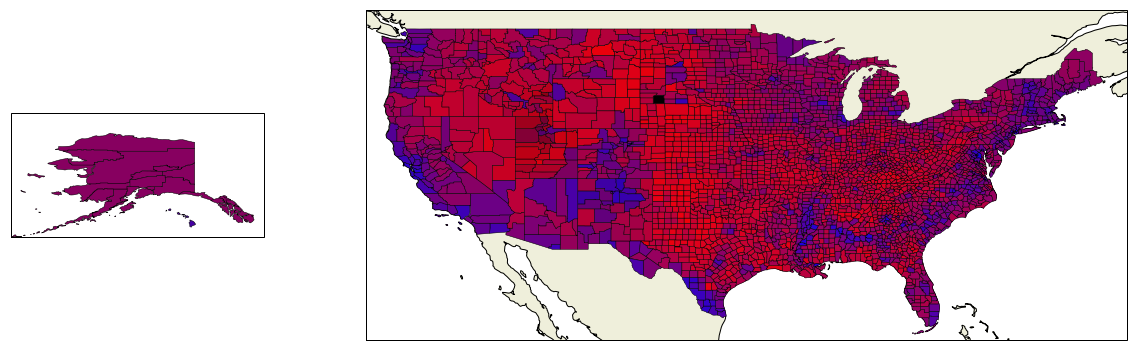

In [492]:
plot_heatmaps_by_count(df=county_level_final)

In [504]:
plot_df = population_and_vote_df.groupby(['combined_fips']).sum()
plot_df['SPREAD'] = (plot_df['votes_dem']-plot_df['votes_gop'])/plot_df['total_votes']
# plot_df['POP_DENSITY'] = plot_df['POP_DENSITY']/plot_df['POP_DENSITY'].max()
# plot_heatmaps_by_count(plot_df, 'TOT_MALE', 'TOT_FEMALE','TOT_POP')

In [451]:
for record in records:
    cols = get_county_voting_color(record, plot_df, 'POP_DENSITY', 'POP_DENSITY', plot_df['POP_DENSITY'].max())
    [print(x) for x in cols if x>1]

True

KeyError: 'combined_fp'

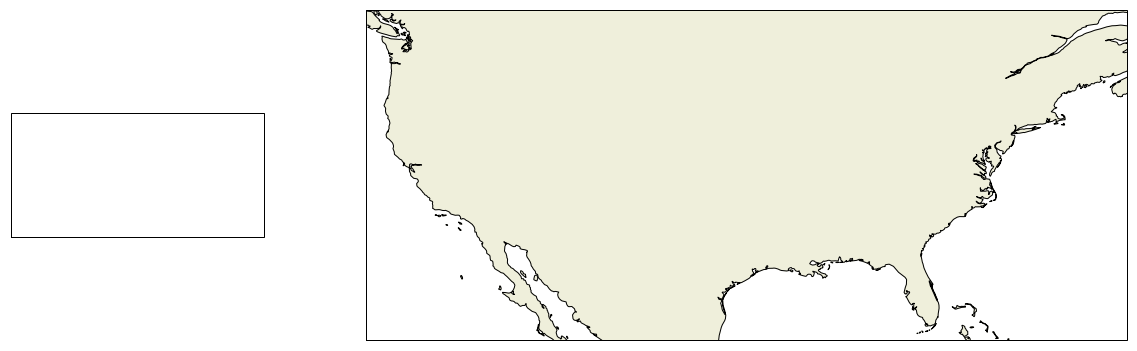

In [505]:
plot_heatmaps_by_count(plot_df, 'TOT_MALE', 'TOT_FEMALE', 'TOT_POP')

In [453]:
plot_heatmaps_by_count(plot_df, 'POP_DENSITY', 'POP_DENSITY', plot_df['POP_DENSITY'].max()/100)

0.12605826866162814,0,0.12605826866162814
0.007633086641652883,0,0.007633086641652883
0.3167966142379879,0,0.3167966142379879
0.0,0,0.0
0.12451080723137539,0,0.12451080723137539
0.045437740531825865,0,0.045437740531825865
0.03169997537675073,0,0.03169997537675073
0.1663730135647255,0,0.1663730135647255
0.11084669150369021,0,0.11084669150369021
0.033452627599541915,0,0.033452627599541915
0.09021346185847502,0,0.09021346185847502
0.11072281199754626,0,0.11072281199754626
0.7308805995101757,0,0.7308805995101757
0.11682395504658043,0,0.11682395504658043
0.19526109877099018,0,0.19526109877099018
0.03152961551668709,0,0.03152961551668709
0.01261981217065976,0,0.01261981217065976
0.37309340536465446,0,0.37309340536465446
0.025019608024450152,0,0.025019608024450152
0.022489566566708686,0,0.022489566566708686
0.02278556242767238,0,0.02278556242767238
0.0,0,0.0
0.007039427467797988,0,0.007039427467797988
0.0,0,0.0
0.011069248751049412,0,0.011069248751049412
0.023377115538306355,0,0.0233771155383

0.19860738067170902,0,0.19860738067170902
0.05587404231356167,0,0.05587404231356167
0.0,0,0.0
0.14617760183388043,0,0.14617760183388043
0.09106792822629377,0,0.09106792822629377
0.4802861578412578,0,0.4802861578412578
0.001949246014251722,0,0.001949246014251722
0.006550734828686308,0,0.006550734828686308
0.23483615980693645,0,0.23483615980693645
0.003335657145934091,0,0.003335657145934091
0.31620640902567393,0,0.31620640902567393
0.13530379749247193,0,0.13530379749247193
0.10649133349656727,0,0.10649133349656727
0.14752158958354544,0,0.14752158958354544
0.2334258348538424,0,0.2334258348538424
0.018324480667458586,0,0.018324480667458586
0.19788206890177862,0,0.19788206890177862
0.008375270525137639,0,0.008375270525137639
0.013382730060731212,0,0.013382730060731212
0.017749455246517585,0,0.017749455246517585
0.07333293236560214,0,0.07333293236560214
0.011759157516959063,0,0.011759157516959063
0.06808313884261429,0,0.06808313884261429
0.00491345607585231,0,0.00491345607585231
0.1141166672

0.12138424756015817,0,0.12138424756015817
0.04451367580055426,0,0.04451367580055426
0.012542736496521798,0,0.012542736496521798
0.056303540027602385,0,0.056303540027602385
0.052041646738140594,0,0.052041646738140594
0.08924473604163455,0,0.08924473604163455
0.2714483161437588,0,0.2714483161437588
0.171015043055391,0,0.171015043055391
0.007210841497869993,0,0.007210841497869993
0.1307929704984171,0,0.1307929704984171
0.12507674622664633,0,0.12507674622664633
0.0016820997025127453,0,0.0016820997025127453
0.43923234251763266,0,0.43923234251763266
0.0734856216818992,0,0.0734856216818992
0.31725952625766496,0,0.31725952625766496
0.04400008346880475,0,0.04400008346880475
0.08178426763861206,0,0.08178426763861206
0.279050509449496,0,0.279050509449496
0.2606998537391105,0,0.2606998537391105
0.029739894872727084,0,0.029739894872727084
0.1848325468852251,0,0.1848325468852251
0.2917569722010032,0,0.2917569722010032
0.0082463732956742,0,0.0082463732956742
0.5939915027880401,0,0.5939915027880401
0.

0.08377889688104147,0,0.08377889688104147
0.030606974192173998,0,0.030606974192173998
0.004912456197703579,0,0.004912456197703579
0.27295376513777486,0,0.27295376513777486
0.03976968798709854,0,0.03976968798709854
0.6251213400431392,0,0.6251213400431392
0.04623200349854912,0,0.04623200349854912
0.06867041286627798,0,0.06867041286627798
0.1605144868912628,0,0.1605144868912628
0.07037665503161705,0,0.07037665503161705
0.08021566487417774,0,0.08021566487417774
0.10004035743952883,0,0.10004035743952883
0.020650067320411355,0,0.020650067320411355
0.005120605978481701,0,0.005120605978481701
0.004638265072678159,0,0.004638265072678159
0.18118901974006155,0,0.18118901974006155
0.12772350985978506,0,0.12772350985978506
0.0018960710631971208,0,0.0018960710631971208
0.6231365436127569,0,0.6231365436127569
2.663894779284989,0,2.663894779284989
0.03434081177917941,0,0.03434081177917941
0.051867303404665534,0,0.051867303404665534
0.0551961225243093,0,0.0551961225243093
0.060893555887857685,0,0.06089

0.13970022357634704,0,0.13970022357634704
0.2853221249612366,0,0.2853221249612366
12.720283803797464,0,12.720283803797464
0.12727384152388263,0,0.12727384152388263
0.020354345622133344,0,0.020354345622133344
0.12292637772689126,0,0.12292637772689126
0.016398163416572565,0,0.016398163416572565
0.14825297005559343,0,0.14825297005559343
0.037220735160697765,0,0.037220735160697765
0.030511259616344974,0,0.030511259616344974
0.05418428752855172,0,0.05418428752855172
0.0027306312094119646,0,0.0027306312094119646
0.08011823936256385,0,0.08011823936256385
0.018694421160618358,0,0.018694421160618358
0.930107433347668,0,0.930107433347668
0.04940742498287118,0,0.04940742498287118
0.00811799966896606,0,0.00811799966896606
0.10152235962314268,0,0.10152235962314268
3.41853426459337,0,3.41853426459337
0.011153574913500521,0,0.011153574913500521
0.0023033884350470296,0,0.0023033884350470296
0.23042243710124724,0,0.23042243710124724
0.005555801517764908,0,0.005555801517764908
0.000849057171302135,0,0.0

0.04400904615758568,0,0.04400904615758568
0.21882179478103322,0,0.21882179478103322
0.013596684012926522,0,0.013596684012926522
0.09514356268716494,0,0.09514356268716494
0.04998389119959806,0,0.04998389119959806
0.5928030840008576,0,0.5928030840008576
0.0018894153281310711,0,0.0018894153281310711
0.009075649959571424,0,0.009075649959571424
0.0,0,0.0
1.9052954270054485,0,1.9052954270054485
0.4803126687326282,0,0.4803126687326282
0.05590923665320868,0,0.05590923665320868
0.5881289284616721,0,0.5881289284616721
0.1289601752972354,0,0.1289601752972354
0.004341707421079331,0,0.004341707421079331
0.14009730441734483,0,0.14009730441734483
0.05608748492017562,0,0.05608748492017562
0.02768941496293601,0,0.02768941496293601
0.21517995203815274,0,0.21517995203815274
0.126809167574107,0,0.126809167574107
0.08080696552533914,0,0.08080696552533914
0.0,0,0.0
0.038451615641850054,0,0.038451615641850054
0.006877266580493119,0,0.006877266580493119
0.14380994908339942,0,0.14380994908339942
0.015013993192

0.004407325921229615,0,0.004407325921229615
0.10868067597323142,0,0.10868067597323142
0.05374845880182083,0,0.05374845880182083
0.05937261267129195,0,0.05937261267129195
0.0016413940675146397,0,0.0016413940675146397
0.004598679450932536,0,0.004598679450932536
0.038865712567125885,0,0.038865712567125885
0.27475954190384944,0,0.27475954190384944
5.503298090622425,0,5.503298090622425
0.22307637139912911,0,0.22307637139912911
0.04657062635942577,0,0.04657062635942577
0.016195089789235093,0,0.016195089789235093
0.1357787901429845,0,0.1357787901429845
0.0028768098274010506,0,0.0028768098274010506
0.0058563793479072266,0,0.0058563793479072266
7.221456115350656,0,7.221456115350656
0.16890731828523373,0,0.16890731828523373
0.051800908808223585,0,0.051800908808223585
0.09371184825689564,0,0.09371184825689564
0.023754468171257467,0,0.023754468171257467
0.048905168138280046,0,0.048905168138280046
2.7039431463246038,0,2.7039431463246038
0.0525635960584973,0,0.0525635960584973
0.013045316156406889,0

0.08911922164021617,0,0.08911922164021617
0.045717702539854584,0,0.045717702539854584
0.04110126623192799,0,0.04110126623192799
0.08525735020802577,0,0.08525735020802577
0.046044334872059466,0,0.046044334872059466
0.1620894209472314,0,0.1620894209472314
0.0984823251489545,0,0.0984823251489545
0.13832880339637266,0,0.13832880339637266
0.21047536885274204,0,0.21047536885274204
0.22909695721712636,0,0.22909695721712636
0.07518125064945613,0,0.07518125064945613
0.20694073973027535,0,0.20694073973027535
0.07114500519249148,0,0.07114500519249148
0.26745072774026785,0,0.26745072774026785
0.08099421632372245,0,0.08099421632372245
0.08452584473781444,0,0.08452584473781444
0.08041765249755645,0,0.08041765249755645
0.059863124849815624,0,0.059863124849815624
10.49464841709557,0,10.49464841709557
0.18787605734705962,0,0.18787605734705962
3.774078327548287,0,3.774078327548287
0.3219778461077743,0,0.3219778461077743
0.004190026854574847,0,0.004190026854574847
0.06269872616058923,0,0.0626987261605892

0.07576373267866701,0,0.07576373267866701
0.1902473809527826,0,0.1902473809527826
1.5612104730158487,0,1.5612104730158487
0.07189007465033016,0,0.07189007465033016
0.29379690052519264,0,0.29379690052519264
0.18009684442577523,0,0.18009684442577523
0.7225255971417515,0,0.7225255971417515
0.07069534152119092,0,0.07069534152119092
0.09850135070250772,0,0.09850135070250772
0.09379237291992236,0,0.09379237291992236
0.07165900726248732,0,0.07165900726248732
0.8676071428301839,0,0.8676071428301839
0.33205359114979016,0,0.33205359114979016
0.0604753154110694,0,0.0604753154110694
0.10213497450857818,0,0.10213497450857818
0.7844510232699298,0,0.7844510232699298
0.0027452276113738355,0,0.0027452276113738355
0.040368461161502396,0,0.040368461161502396
0.0637444809487935,0,0.0637444809487935
0.012552374681728283,0,0.012552374681728283
0.052659351706842876,0,0.052659351706842876
0.051882646965526635,0,0.051882646965526635
0.3061258875769331,0,0.3061258875769331
0.008212969783756059,0,0.0082129697837

0.18000412840240188,0,0.18000412840240188
0.0339172855420699,0,0.0339172855420699
0.08641944924101652,0,0.08641944924101652
2.21888625172984,0,2.21888625172984
0.10291196167768304,0,0.10291196167768304
0.1339571203670283,0,0.1339571203670283
0.20578596168149588,0,0.20578596168149588
0.5115227019580624,0,0.5115227019580624
0.023055945187419383,0,0.023055945187419383
0.02720280878163323,0,0.02720280878163323
0.019077662494637486,0,0.019077662494637486
0.14969325116088894,0,0.14969325116088894
0.6979946029408993,0,0.6979946029408993
0.171573195438182,0,0.171573195438182
0.023238903687636068,0,0.023238903687636068
0.08770929183982283,0,0.08770929183982283
0.1061699424082487,0,0.1061699424082487
0.005164472339789126,0,0.005164472339789126
0.0931136679270293,0,0.0931136679270293
0.044085565636623525,0,0.044085565636623525
0.03324934567516391,0,0.03324934567516391
0.01936407364861547,0,0.01936407364861547
0.0006928513647946857,0,0.0006928513647946857
0.012330330808560276,0,0.01233033080856027

0.08156906908283448,0,0.08156906908283448
0.2866756239661075,0,0.2866756239661075
0.08845628356661651,0,0.08845628356661651
0.2534959259284906,0,0.2534959259284906
0.05993455779100965,0,0.05993455779100965
0.07579657933300948,0,0.07579657933300948
0.3191804636727617,0,0.3191804636727617
0.21034276383942124,0,0.21034276383942124
0.1496090650324321,0,0.1496090650324321
0.03961064189982792,0,0.03961064189982792
0.018362262208492516,0,0.018362262208492516
0.04616971900608916,0,0.04616971900608916
0.09544785397233925,0,0.09544785397233925
0.08405392580239889,0,0.08405392580239889
3.517221383321393,0,3.517221383321393
0.0927628486667272,0,0.0927628486667272
0.057112624146462766,0,0.057112624146462766
0.26074581090745264,0,0.26074581090745264
0.21295422138465558,0,0.21295422138465558
0.28364819224887855,0,0.28364819224887855
0.008629038627919207,0,0.008629038627919207
0.19162675262039217,0,0.19162675262039217
0.3951279636744477,0,0.3951279636744477
0.7307867627563236,0,0.7307867627563236
0.17

0.2384435099035701,0,0.2384435099035701
0.03784877132378081,0,0.03784877132378081
0.07560773959248185,0,0.07560773959248185
0.4720989941844158,0,0.4720989941844158
0.1701756319774529,0,0.1701756319774529
0.08934656083550115,0,0.08934656083550115
0.014985297552112933,0,0.014985297552112933
0.43426250714854236,0,0.43426250714854236
0.0,0,0.0
0.0,0,0.0
0.14376398125420167,0,0.14376398125420167
0.06245355871433106,0,0.06245355871433106
0.00738510200432268,0,0.00738510200432268
0.002746310081027571,0,0.002746310081027571
0.1516149508792106,0,0.1516149508792106
0.048557932112786584,0,0.048557932112786584
0.1266309585256825,0,0.1266309585256825
0.12395093670215727,0,0.12395093670215727
0.2331486233179784,0,0.2331486233179784
0.004657074798490063,0,0.004657074798490063
0.259832464245914,0,0.259832464245914
0.015339450977491844,0,0.015339450977491844
4.08557578972758,0,4.08557578972758
0.2073757791464615,0,0.2073757791464615
1.388852189564863,0,1.388852189564863
0.033810102765458615,0,0.0338101

0.11022467279469968,0,0.11022467279469968
0.2868849560526686,0,0.2868849560526686
0.6425579647531451,0,0.6425579647531451
2.6715539739262324,0,2.6715539739262324
0.10226432980037307,0,0.10226432980037307
0.0,0,0.0
0.7628034055761644,0,0.7628034055761644
0.01798128651472302,0,0.01798128651472302
0.5136497961522835,0,0.5136497961522835
0.6676550732640255,0,0.6676550732640255
0.09329520177819732,0,0.09329520177819732
0.06015138533935229,0,0.06015138533935229
8.64572302915041,0,8.64572302915041
0.0157799508793204,0,0.0157799508793204
0.11148070782603345,0,0.11148070782603345
0.005751223745122858,0,0.005751223745122858
0.03497556905861022,0,0.03497556905861022
0.2587144341688193,0,0.2587144341688193
0.018377526562406654,0,0.018377526562406654
1.8006912850507104,0,1.8006912850507104
0.15853524317400575,0,0.15853524317400575
0.04755646486350815,0,0.04755646486350815
0.02611947920476441,0,0.02611947920476441
0.009004417515213673,0,0.009004417515213673
0.08739963404384375,0,0.08739963404384375


0.045331103095215756,0,0.045331103095215756
0.05604651397343204,0,0.05604651397343204
0.795122310955155,0,0.795122310955155
0.11047350091226461,0,0.11047350091226461
0.10617300373264847,0,0.10617300373264847
0.005447278172345479,0,0.005447278172345479
0.09399499270433001,0,0.09399499270433001
2.7067917803396333,0,2.7067917803396333
0.009048600695628121,0,0.009048600695628121
0.03357076433971264,0,0.03357076433971264
0.33419280462886186,0,0.33419280462886186
0.1820734561791058,0,0.1820734561791058
0.0511291917854245,0,0.0511291917854245
0.0,0,0.0
0.13348842185879295,0,0.13348842185879295
0.0030967224927772705,0,0.0030967224927772705
0.2688747409777969,0,0.2688747409777969
0.10088883079277648,0,0.10088883079277648
0.0,0,0.0
0.0,0,0.0
0.29002782506510766,0,0.29002782506510766
0.08084973495344655,0,0.08084973495344655
0.05894933316806903,0,0.05894933316806903
0.01606443160837899,0,0.01606443160837899
0.5377635817956071,0,0.5377635817956071
0.01885450342360747,0,0.01885450342360747
0.529717

0.07091234174841402,0,0.07091234174841402
0.04594398968237131,0,0.04594398968237131
0.7895547227182385,0,0.7895547227182385
0.6782709112331096,0,0.6782709112331096
0.018254717139331373,0,0.018254717139331373
0.46093281358294813,0,0.46093281358294813
0.04674404077530752,0,0.04674404077530752
0.029702384027744982,0,0.029702384027744982
0.04460320995545972,0,0.04460320995545972
0.05068624177781149,0,0.05068624177781149
1.7707102325490949,0,1.7707102325490949
0.2797144147359255,0,0.2797144147359255
0.06996458444072687,0,0.06996458444072687
0.3202742091231276,0,0.3202742091231276
0.006044286542808693,0,0.006044286542808693
0.029873870496281103,0,0.029873870496281103
0.1339472371452877,0,0.1339472371452877
0.08453369939874532,0,0.08453369939874532
0.6016812013526839,0,0.6016812013526839
1.9901393445865874,0,1.9901393445865874
0.2719401952939754,0,0.2719401952939754
0.03797059380047598,0,0.03797059380047598
0.08701436995787395,0,0.08701436995787395
0.09943097294817314,0,0.09943097294817314
0.

9.611828476562945,0,9.611828476562945
0.11680895280858031,0,0.11680895280858031
0.2856711824561593,0,0.2856711824561593
0.886301804586634,0,0.886301804586634
0.0863225438991849,0,0.0863225438991849
0.1318650989289917,0,0.1318650989289917
0.158876756235771,0,0.158876756235771
0.04630665021680448,0,0.04630665021680448
0.4007958071016043,0,0.4007958071016043
0.11182227504957756,0,0.11182227504957756
1.486937630342701,0,1.486937630342701
0.1767151013135192,0,0.1767151013135192
1.0603332662173344,0,1.0603332662173344
1.0498013992913724,0,1.0498013992913724
0.02007684472518571,0,0.02007684472518571
0.7629074005108265,0,0.7629074005108265
0.0019358383011710985,0,0.0019358383011710985
0.010221471527283924,0,0.010221471527283924
0.05481204780272559,0,0.05481204780272559
0.11811325162125508,0,0.11811325162125508
0.07876782953032342,0,0.07876782953032342
0.17292229374807602,0,0.17292229374807602
0.036244361446002675,0,0.036244361446002675
0.12360772606338144,0,0.12360772606338144
0.06691262080301

ValueError: Invalid RGBA argument: 3.2142634500693736

<Figure size 1440x1008 with 2 Axes>

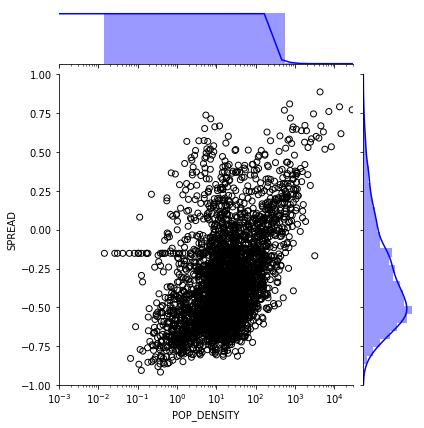

In [515]:
g = sns.JointGrid('POP_DENSITY', 'SPREAD', plot_df, xlim=[.001,30000],ylim=[-1,1])
g.plot_marginals(sns.distplot, hist=True, kde=True, color='blue')
g.plot_joint(plt.scatter, color='none', edgecolor='black')
ax = g.ax_joint
ax.set_xscale('log')
# ax.set_yscale('log')
g.ax_marg_x.set_xscale('log')
# g.ax_marg_y.set_yscale('log')

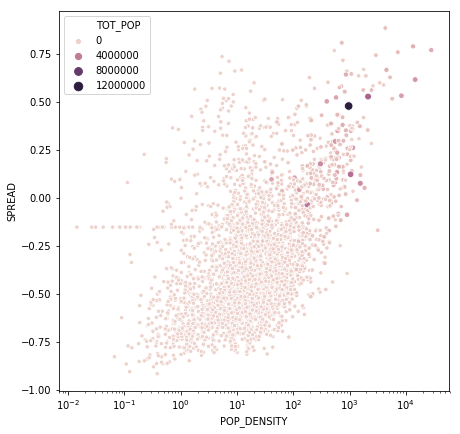

In [523]:
f, ax = plt.subplots(figsize=(7, 7))
ax.set(xscale="log")
g = sns.scatterplot(x='POP_DENSITY', y='SPREAD', data=plot_df, size='TOT_POP', hue='TOT_POP', ax=ax, )

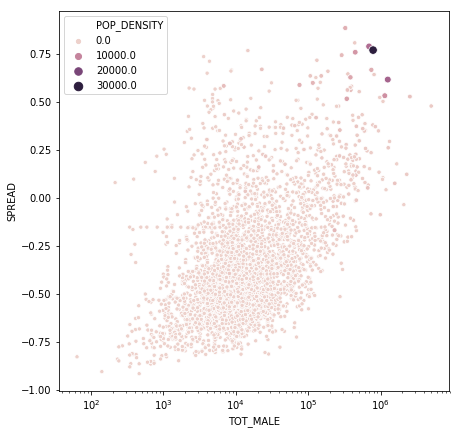

In [524]:
f, ax = plt.subplots(figsize=(7, 7))
ax.set(xscale="log")
g = sns.scatterplot(x='TOT_MALE', y='SPREAD', data=plot_df, size='POP_DENSITY', hue='POP_DENSITY', ax=ax, )

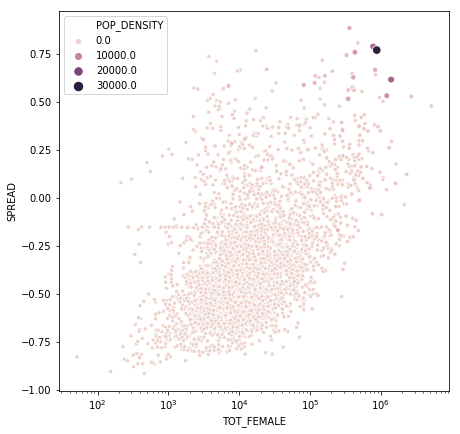

In [525]:
f, ax = plt.subplots(figsize=(7, 7))
ax.set(xscale="log")
g = sns.scatterplot(x='TOT_FEMALE', y='SPREAD', data=plot_df, size='POP_DENSITY', hue='POP_DENSITY', ax=ax, )

In [507]:
plot_df[['SPREAD','POP_DENSITY']].describe()

,SPREAD,POP_DENSITY
count,3139.000000,3142.000000
mean,-0.317910,104.982551
std,0.307283,706.970288
min,-0.916364,0.014362
25%,-0.545159,6.476804
50%,-0.378583,17.265151
75%,-0.151697,44.939590
max,0.887245,28327.194534


In [479]:
county_pop_density = np.zeros((len(records),3))
for i, record in enumerate(records):
    county_pop_density[i,:] = get_county_voting_color(record, plot_df, 'POP_DENSITY', 'POP_DENSITY', plot_df['POP_DENSITY'].max())

In [534]:
# plot_df.head()
plot_df.columns

Index(['SUMLEV', 'STATE', 'COUNTY', 'YEAR', 'AGEGRP', 'TOT_POP', 'TOT_MALE',
       'TOT_FEMALE', 'WA_MALE', 'WA_FEMALE', 'BA_MALE', 'BA_FEMALE', 'IA_MALE',
       'IA_FEMALE', 'AA_MALE', 'AA_FEMALE', 'NA_MALE', 'NA_FEMALE', 'TOM_MALE',
       'TOM_FEMALE', 'WAC_MALE', 'WAC_FEMALE', 'BAC_MALE', 'BAC_FEMALE',
       'IAC_MALE', 'IAC_FEMALE', 'AAC_MALE', 'AAC_FEMALE', 'NAC_MALE',
       'NAC_FEMALE', 'NH_MALE', 'NH_FEMALE', 'NHWA_MALE', 'NHWA_FEMALE',
       'NHBA_MALE', 'NHBA_FEMALE', 'NHIA_MALE', 'NHIA_FEMALE', 'NHAA_MALE',
       'NHAA_FEMALE', 'NHNA_MALE', 'NHNA_FEMALE', 'NHTOM_MALE', 'NHTOM_FEMALE',
       'NHWAC_MALE', 'NHWAC_FEMALE', 'NHBAC_MALE', 'NHBAC_FEMALE',
       'NHIAC_MALE', 'NHIAC_FEMALE', 'NHAAC_MALE', 'NHAAC_FEMALE',
       'NHNAC_MALE', 'NHNAC_FEMALE', 'H_MALE', 'H_FEMALE', 'HWA_MALE',
       'HWA_FEMALE', 'HBA_MALE', 'HBA_FEMALE', 'HIA_MALE', 'HIA_FEMALE',
       'HAA_MALE', 'HAA_FEMALE', 'HNA_MALE', 'HNA_FEMALE', 'HTOM_MALE',
       'HTOM_FEMALE', 'HWAC_MALE', 'HWAC

In [714]:
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier  #GBM algorithm
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4


In [728]:
plot_df_no_nan = plot_df[plot_df.isnull().any(axis=1)==False]
X = plot_df_no_nan.reset_index().drop(['combined_fips', 'SUMLEV', 'STATE', 'COUNTY', 'YEAR', 'AGEGRP', 'votes_dem', 'votes_gop', 'total_votes', 'per_dem', 'per_gop', 'SPREAD'], axis=1).astype(np.float32)
y = plot_df_no_nan['SPREAD'].values
y = y.reshape(-1,1)
y = y.astype(np.float32)
y = np.sign(y)
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.1, random_state=41)

In [729]:
params = {'n_estimators': 5000, 'max_depth': 100, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)
mse = mean_squared_error(y_test, clf.predict(X_test))
print("MSE: %.4f" % mse)

test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MSE: 0.4028


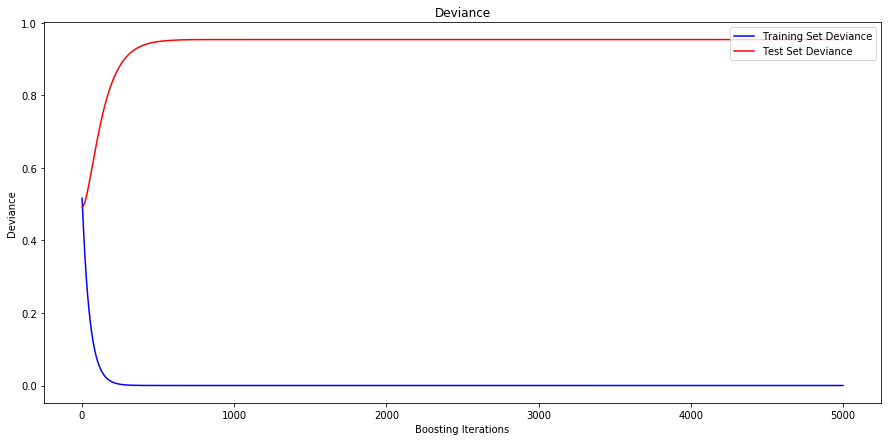

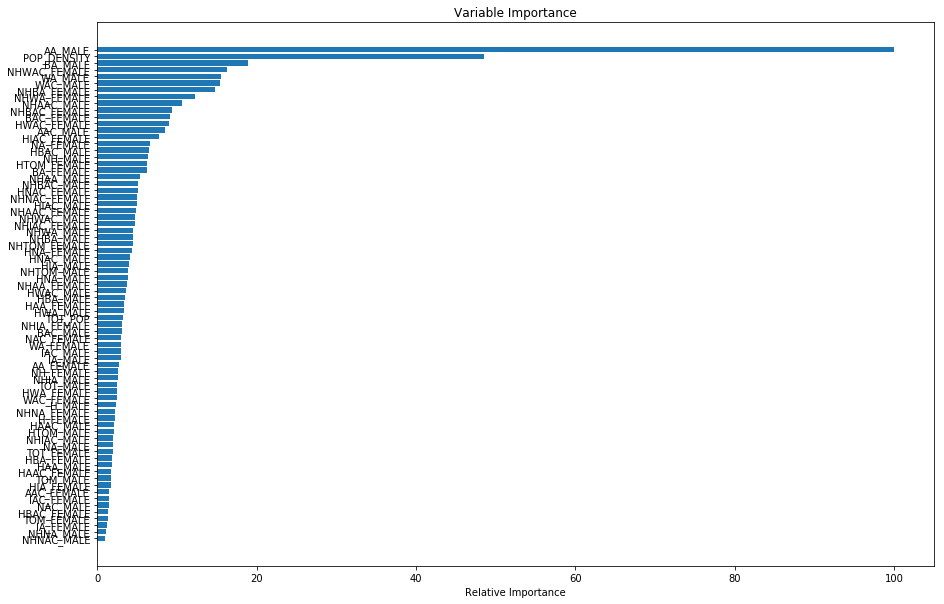

In [730]:
f, ax = plt.subplots(figsize=(15, 7))
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

f, ax = plt.subplots(figsize=(15, 10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [731]:
print("Top 5 predictors:\n")
for x in range(1,6):
    print("{}\t=== {}".format(X.columns[sorted_idx][-x], legend[X.columns[sorted_idx][-x]]))

Top 5 predictors:

AA_MALE	=== Asian alone male population
POP_DENSITY	=== Population Density
BA_MALE	=== Black or African American alone male population
NHWAC_FEMALE	=== Not Hispanic, White alone or in combination female population
WA_MALE	=== White alone male population


In [726]:
label_encoded_y = LabelEncoder().fit_transform(np.sign(y).ravel())
model = XGBClassifier()
subsample = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]
param_grid = dict(subsample=subsample)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)

In [727]:
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold.split(X_train, y_train))
grid_result = grid_search.fit(X, label_encoded_y)

ValueError: Supported target types are: ('binary', 'multiclass'). Got 'continuous' instead.

In [ ]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
plt.errorbar(subsample, means, yerr=stds)
plt.title("XGBoost subsample vs Log Loss")
plt.xlabel('subsample')
plt.ylabel('Log Loss')
